In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Sequential

# import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from glob import glob

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
train_path = '/content/drive/My Drive/training_set/training_set'
test_path = '/content/drive/My Drive/test_set/test_set'

In [4]:
a = os.listdir(train_path)
b = os.listdir(test_path)

print(a)
print(b)

['cats', 'dogs']
['cats', 'dogs']


In [5]:
IMAGE_SIZE = [224,224,3]

In [6]:
vgg = VGG16(input_shape = IMAGE_SIZE, weights = 'imagenet', include_top = False) # 

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
for layer in vgg.layers:
  layer.trainable = False

In [8]:
folders = glob('/content/drive/My Drive/training_set/training_set/*')

In [9]:
x = Flatten()(vgg.output)

In [10]:
prediction = Dense(len(folders), activation = 'softmax')(x)            # len(folders) = 2 (cats and dogs)

In [11]:
model = Model(inputs = vgg.input, outputs = prediction)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/content/drive/My Drive/training_set/training_set',
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/test_set/test_set',
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [15]:
model_history = model.fit_generator(train_set,
                                    validation_data = test_set,
                                    epochs = 5,
                                    steps_per_epoch = len(train_set) // 64,
                                    validation_steps = len(test_set) // 64)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
3/3 [==============================] - 32s 11s/step - loss: 1.2630 - accuracy: 0.4583 - val_loss: 0.9498 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 36s 12s/step - loss: 0.8331 - accuracy: 0.5938 - val_loss: 0.6053 - val_accuracy: 0.6562
Epoch 3/5
3/3 [==============================] - 42s 14s/step - loss: 0.7078 - accuracy: 0.6250 - val_loss: 0.6067 - val_accuracy: 0.6875
Epoch 4/5
3/3 [==============================] - 36s 12s/step - loss: 0.4979 - accuracy: 0.7812 - val_loss: 0.6220 - val_accuracy: 0.6250
Epoch 5/5
3/3 [==============================] - 37s 12s/step - loss: 0.3802 - accuracy: 0.8125 - val_loss: 0.3737 - val_accuracy: 0.8438


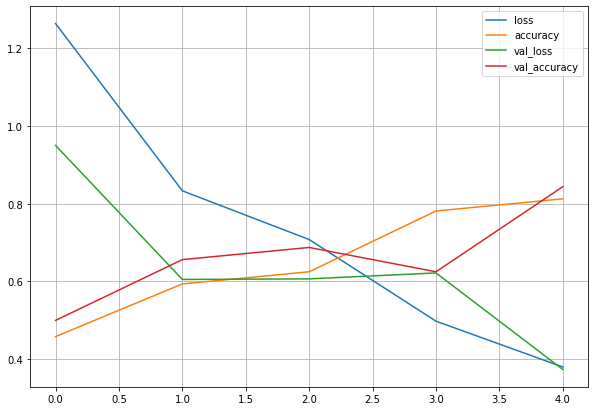

In [16]:
pd.DataFrame(model_history.history).plot(figsize = (10,7))
plt.gca()
plt.grid(True)

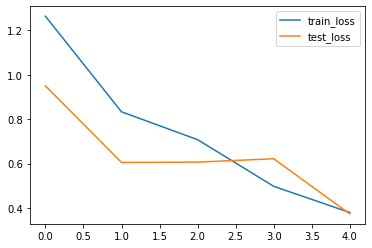

In [17]:
plt.plot(model_history.history['loss'], label = 'train_loss')
plt.plot(model_history.history['val_loss'], label = 'test_loss')
plt.legend()
plt.show()

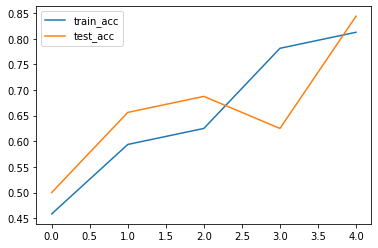

In [18]:
plt.plot(model_history.history['accuracy'], label = 'train_acc')
plt.plot(model_history.history['val_accuracy'], label = 'test_acc')
plt.legend()
plt.show()

In [19]:
from keras.models import load_model

model.save('cats&dogs_new_model.h5')